# Adversarial Patch for Resnet 34

### Importing essential libraries for data manipulation, plotting, model training, handling external datasets, model development and datasets, with PyTorch Lightning for improved training loops


In [1]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

import urllib.request
from urllib.error import HTTPError
import zipfile

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint


<ipython-input-1-dccec7072140>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


 - Setting up paths for datasets and pretrained model checkpoints.
 - Setting random seed for reproducibility and selecting GPU (if available) as the device for computations.


In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


# Downloading the TinyImageNet dataset and pretrained patches from a GitHub repository and unzipping the files.

In [3]:
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

Unzipping file...
Unzipping file...


## Deep CNNs on ImageNet

Loading the model ResNet34

In [4]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ../saved_models/tutorial10/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 151MB/s]


In [5]:
# Mean and standard deviation for normalizing images using the standard ImageNet statistics
NORM_MEAN = np.array([0.485, 0.456, 0.406])  # Mean RGB values for ImageNet
NORM_STD = np.array([0.229, 0.224, 0.225])   # Standard deviation for ImageNet

# Transformation pipeline for preprocessing the images:
# Converts the images to tensors and normalizes them using ImageNet statistics.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=NORM_MEAN, std=NORM_STD)  # Normalize using ImageNet mean and std
])

# Load the TinyImageNet dataset and create a DataLoader for batching and shuffling data.
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Ensure that the dataset is downloaded, or update the {DATASET_PATH=} variable."
# Loading the dataset using ImageFolder, which assumes images are organized by class folders.
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)

# DataLoader to iterate over the dataset in batches of 32 images.
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names from a JSON file for mapping class indices to their corresponding labels.
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

# Function to get the index of a label (class name) from the list of label names.
def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Verifing the performance of the model before adversirial attack.

In [6]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [7]:
_ = eval_model(data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 19.38%
Top-5 error: 4.38%


In [8]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

Visualizing few images below to test the model (prior to adversial attack)

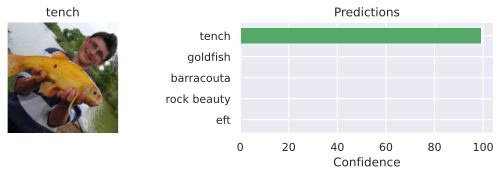

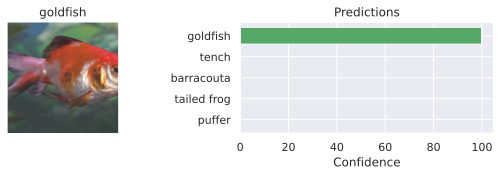

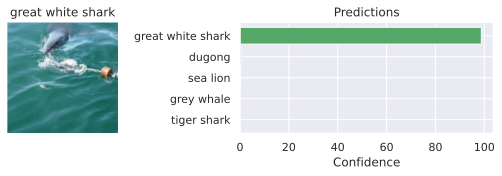

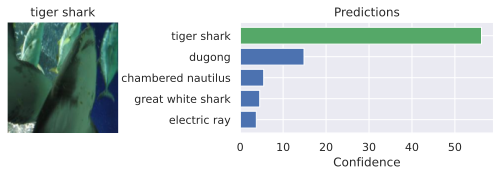

In [9]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

### Adversarial Patches

Reference: [Brown et al.](https://arxiv.org/pdf/1712.09665.pdf)

Function to randomly place an adversarial patch on an image.
For each image in the batch, a random offset for height and width is selected,
and the patch is placed at that location. The patch is applied to all images
in the batch, modifying the pixel values in the corresponding region.

In [27]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

Function to normalize the adversarial patch values to valid image pixel ranges.
Applies the tanh function to map the patch values from [-infty, infty] to [-1, 1],followed by rescaling to the ImageNet pixel distribution using precomputed means and stds.

In [28]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

Function to evaluate the effectiveness of an adversarial patch on a model.
The patch is placed at 4 random locations on each image in the validation set to
stabilize the evaluation, and the model's predictions are recorded.
The function computes:
- True Positives (tp): Cases where the model predicts the target class (excluding true target class images).
- Top-5 accuracy (tp_5): Cases where the target class appears in the top 5 predictions.
 The function returns the overall accuracy and top-5 accuracy of the adversarial patch.


In [29]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

Function to train an adversarial patch to mislead a model into predicting a target class.
The function creates a train and validation split from the dataset, then iteratively optimizes the patch.
For each image in the training set, the patch is randomly placed and the model is trained to predict the target class.
The patch is updated using stochastic gradient descent (SGD) to minimize cross-entropy loss.
After training, the patch is evaluated on the validation set using the eval_patch function, which returns accuracy metrics.


In [30]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [31]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [32]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

# Generating patches for mask strawberry and police van in the size 16,32 and 64

In [ ]:
class_names = ['mask', 'strawberry', 'police van']
patch_sizes = [16, 32, 64]

patch_dict = get_patches(class_names, patch_sizes)
save_results(patch_dict)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for mask and 16: {'acc': 0.0, 'top5': 0.01302605215460062}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for mask and 32: {'acc': 0.2615000009536743, 'top5': 0.6060000061988831}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for mask and 64: {'acc': 0.9884999990463257, 'top5': 0.9984999895095825}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for strawberry and 16: {'acc': 0.0, 'top5': 0.02250000089406967}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for strawberry and 32: {'acc': 0.7710421085357666, 'top5': 0.9203406572341919}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for strawberry and 64: {'acc': 0.9745000004768372, 'top5': 0.9994999766349792}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for police van and 16: {'acc': 0.0005010020104236901, 'top5': 0.012024047784507275}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for police van and 32: {'acc': 0.24599198997020721, 'top5': 0.5836673378944397}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for police van and 64: {'acc': 0.9452811479568481, 'top5': 0.9944779276847839}


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

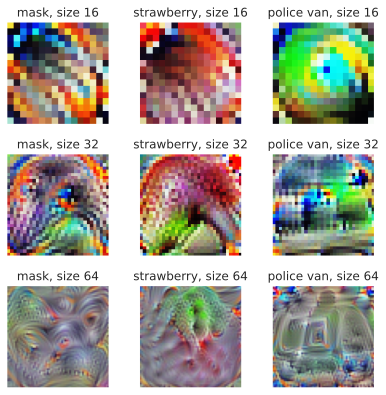

In [ ]:
def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
show_patches()

In [ ]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

In [ ]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

First, we will create a table of top-1 accuracy, meaning that how many images have been classified with the target class as highest prediction. We see the accuracy significantly increases with pixel

In [ ]:
show_table(top_1=True)

In [ ]:
show_table(top_1=False)

In [ ]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

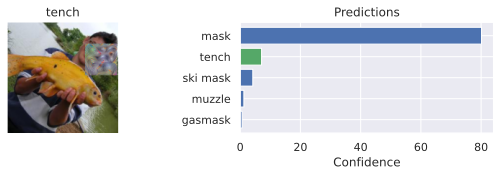

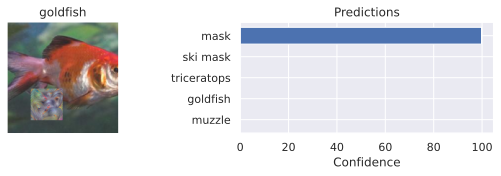

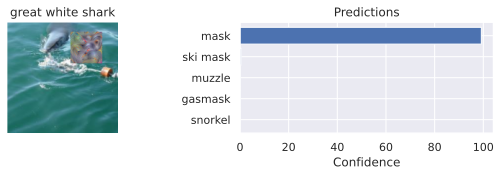

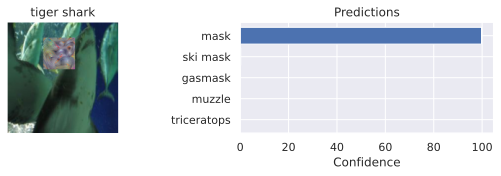

In [ ]:
perform_patch_attack(patch_dict['mask'][64]['patch'])

The tiny goldfish patch can change all of the predictions to "goldfish" as top class. Note that the patch attacks work especially well if the input image is semantically similar to the target class (e.g. a fish and the target class "goldfish" works better than an airplane image with that patch). Nevertheless, we can also let the network predict semantically dis-similar classes by using a larger patch:

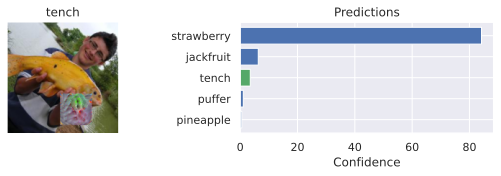

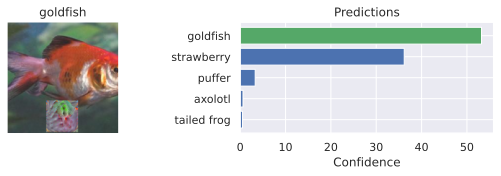

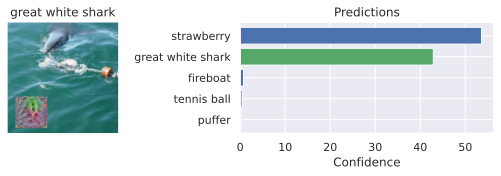

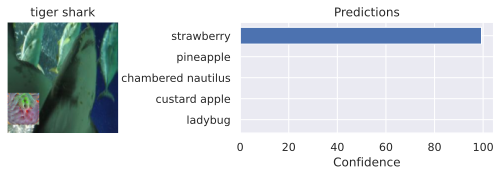

In [ ]:
perform_patch_attack(patch_dict['strawberry'][64]['patch'])

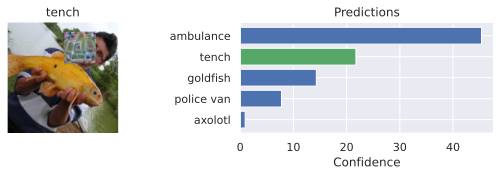

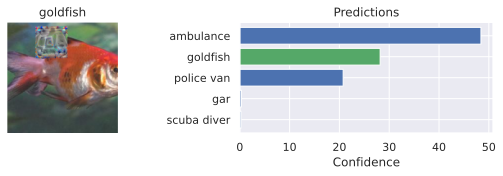

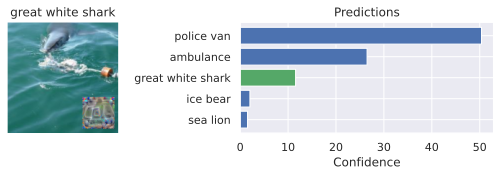

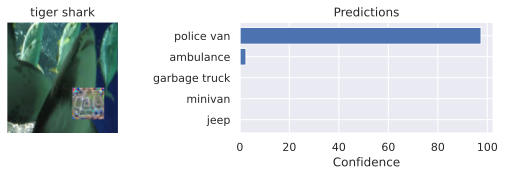

In [ ]:
perform_patch_attack(patch_dict['police van'][64]['patch'])

# Masking the image with smiley

In [12]:
# Function to create a smiley face within a circular mask and ensure black background
def create_smiley_mask(patch_size):
    mask = np.ones((patch_size, patch_size), dtype=np.float32)  # Start with all ones (white background for the patch)
    radius = patch_size // 2
    y, x = np.ogrid[-radius:radius, -radius:radius]
    mask_circle = x ** 2 + y ** 2 <= radius ** 2  # Circle mask

    # Set the area outside the circle to zero (black background)
    mask[~mask_circle] = 0

    # Add smiley features inside the circle (you can adjust these for customization)
    eye_y, eye_x = radius // 2, radius // 3
    mask[eye_y-3:eye_y+3, eye_x-3:eye_x+3] = 0  # Left eye (black)
    mask[eye_y-3:eye_y+3, patch_size - eye_x-3:patch_size - eye_x+3] = 0  # Right eye (black)
    mask[radius + 5:radius + 8, radius-8:radius + 8] = 0  # Mouth (black)

    return torch.FloatTensor(mask).unsqueeze(0).repeat(3, 1, 1)  # 3 channels for RGB

In [13]:
# Function to place a circular patch with a black background and smiley face on the image
def place_patch(img, patch, mask):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0, img.shape[2] - patch.shape[1] - 1)
        w_offset = np.random.randint(0, img.shape[3] - patch.shape[2] - 1)
        img_patch = patch_forward(patch) * mask
        img[i, :, h_offset:h_offset + patch.shape[1], w_offset:w_offset + patch.shape[2]] = img_patch
    return img

In [14]:
def patch_forward(patch):
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [15]:
def eval_patch(model, patch, mask, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            for _ in range(4):
                patch_img = place_patch(img, patch, mask)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp / counter
    top5 = tp_5 / counter
    return acc, top5

In [16]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create patch and mask
    patch = nn.Parameter(torch.zeros(3, patch_size, patch_size), requires_grad=True)
    mask = create_smiley_mask(patch_size)

    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch, mask)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, mask, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [17]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            result_dict[name][patch_size] = {
                "patch": patch
            }
    return result_dict

In [18]:
def show_patches(patch_dict, class_names, patch_sizes):
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))

    if len(patch_sizes) == 1:
        ax = [ax]
    if len(class_names) == 1:
        ax = [[a] for a in ax]

    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)

            # Ensure black background outside the circle
            background = np.zeros_like(patch)
            mask = create_smiley_mask(psize).cpu().numpy().transpose(1, 2, 0)
            patch = patch * mask + background * (1 - mask)

            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')

    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Validating...:   0%|          | 0/16 [00:00<?, ?it/s]

Validation results for flamingo and 64: {'acc': 0.9559999704360962, 'top5': 0.9929999709129333}


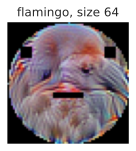

In [19]:
# Example usage
class_names = ['flamingo']
patch_sizes = [64]

patch_dict = get_patches(class_names, patch_sizes)
show_patches(patch_dict, class_names, patch_sizes)

# Testing with overlaying two patches

<ipython-input-36-b1e531b0534e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file_name)


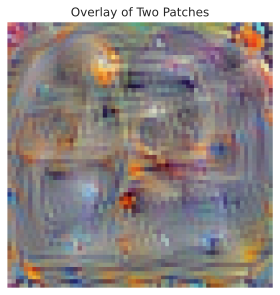

In [36]:
def load_patch(file_name):
    """
    Load a saved patch from a .pt file.
    """
    return torch.load(file_name)

def combine_patches(patch1, patch2, method="overlay"):
    """
    Combine two patches into one.
    :param patch1: The first patch (tensor).
    :param patch2: The second patch (tensor).
    :param method: Method to combine patches: 'overlay' (averaging) or 'concat' (side-by-side).
    :return: Combined patch.
    """
    if method == "overlay":
        # Overlay the patches by averaging their pixel values
        combined_patch = (patch1 + patch2) / 2
    elif method == "concat":
        # Concatenate the patches side by side (make sure both patches have the same height)
        assert patch1.shape[1] == patch2.shape[1], "Patches must have the same height to concatenate."
        combined_patch = torch.cat((patch1, patch2), dim=2)  # Concatenate along the width
    else:
        raise ValueError("Invalid method. Choose 'overlay' or 'concat'.")

    return combined_patch
def visualize_patch(patch, title="Combined Patch"):
    """
    Visualizes the given patch using matplotlib.
    :param patch: The patch tensor to visualize (in the shape [C, H, W]).
    :param title: Title of the plot.
    """
    # Convert the patch from [C, H, W] to [H, W, C] format and clip values to [0, 1]
    patch = patch.permute(1, 2, 0).detach().cpu().numpy()
    patch = (patch - patch.min()) / (patch.max() - patch.min())  # Normalize to [0, 1] range for visualization

    # Display the patch using matplotlib
    plt.imshow(patch)
    plt.title(title)
    plt.axis('off')  # Turn off axis
    plt.show()

# Load two patches
patch1 = load_patch("/saved_models/tutorial10/school bus_64_patch.pt")  # Replace with actual file paths
patch2 = load_patch("/saved_models/tutorial10/toaster_64_patch.pt")

# Combine the patches (choose either 'overlay' or 'concat' method)
combined_patch = combine_patches(patch1, patch2, method="overlay")
# Visualize the combined patch
visualize_patch(combined_patch, title="Overlay of Two Patches")

In [37]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

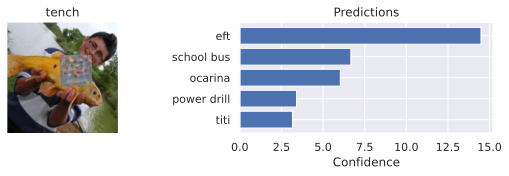

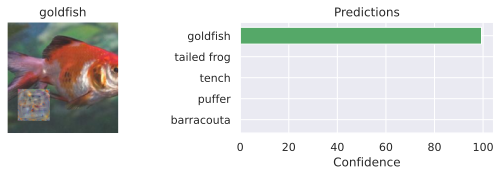

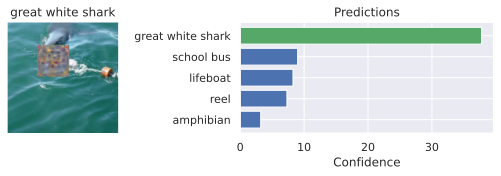

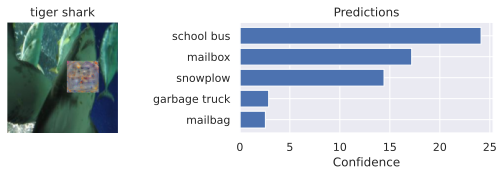

In [38]:
perform_patch_attack(combined_patch)

# Trying on different models

In [ ]:
transfer_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
transfer_model = transfer_model.to(device)

# No gradients needed for the network
transfer_model.eval()
for p in transfer_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to ../saved_models/tutorial10/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 163MB/s]


In [ ]:
class_name = 'mask'
patch_size = 64
print(f"Testing patch \"{class_name}\" of size {patch_size}x{patch_size}")

results = eval_patch(transfer_model,
                     patch_dict[class_name][patch_size]["patch"],
                     data_loader,
                     target_class=label_names.index(class_name))

print(f"Top-1 fool accuracy: {(results[0] * 100.0):4.2f}%")
print(f"Top-5 fool accuracy: {(results[1] * 100.0):4.2f}%")

Testing patch "mask" of size 64x64


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Top-1 fool accuracy: 32.89%
Top-5 fool accuracy: 57.60%


In [ ]:
transfer_model = torchvision.models.vgg11(weights='IMAGENET1K_V1')
transfer_model = transfer_model.to(device)

# No gradients needed for the network
transfer_model.eval()
for p in transfer_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to ../saved_models/tutorial10/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:18<00:00, 28.7MB/s]


In [ ]:
class_name = 'mask'
patch_size = 64
print(f"Testing patch \"{class_name}\" of size {patch_size}x{patch_size}")

results = eval_patch(transfer_model,
                     patch_dict[class_name][patch_size]["patch"],
                     data_loader,
                     target_class=label_names.index(class_name))

print(f"Top-1 fool accuracy: {(results[0] * 100.0):4.2f}%")
print(f"Top-5 fool accuracy: {(results[1] * 100.0):4.2f}%")

Testing patch "mask" of size 64x64


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Top-1 fool accuracy: 28.78%
Top-5 fool accuracy: 64.58%


In [ ]:
transfer_model = torchvision.models.googlenet(weights='IMAGENET1K_V1')
transfer_model = transfer_model.to(device)

# No gradients needed for the network
transfer_model.eval()
for p in transfer_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to ../saved_models/tutorial10/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 161MB/s]


In [ ]:
class_name = 'mask'
patch_size = 64
print(f"Testing patch \"{class_name}\" of size {patch_size}x{patch_size}")

results = eval_patch(transfer_model,
                     patch_dict[class_name][patch_size]["patch"],
                     data_loader,
                     target_class=label_names.index(class_name))

print(f"Top-1 fool accuracy: {(results[0] * 100.0):4.2f}%")
print(f"Top-5 fool accuracy: {(results[1] * 100.0):4.2f}%")

Testing patch "mask" of size 64x64


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 fool accuracy: 53.82%
Top-5 fool accuracy: 77.84%


# To export as jpg file

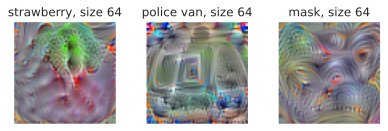

In [ ]:
import os

def save_patch_as_jpg(patch, save_path, cname, psize):
    # Convert the patch to a format that can be saved as an image
    patch = (torch.tanh(patch) + 1) / 2  # Convert parameter values to pixel values
    patch = patch.cpu().permute(1, 2, 0).numpy()  # Convert tensor to numpy
    patch = np.clip(patch, a_min=0.0, a_max=1.0)  # Ensure pixel values are in valid range

    # Save the patch as a .jpg file
    plt.imsave(f"{save_path}/{cname}_patch_size_{psize}.jpg", patch)

def show_and_save_patches(patch_dict, class_names, patch_sizes, save_path="patch_images"):
    # Ensure the save path directory exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names) * 2.2, len(patch_sizes) * 2.2))

    # Handle cases where ax may not be a 2D array (i.e., if there's only one row/col)
    if len(patch_sizes) == 1:
        ax = [ax]  # Convert to a list for consistent indexing
    if len(class_names) == 1:
        ax = [[a] for a in ax]  # Ensure ax is a 2D array (list of lists)

    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]

            # Show the patch
            patch_img = (torch.tanh(patch) + 1) / 2  # Convert parameter values to pixel values
            patch_img = patch_img.cpu().permute(1, 2, 0).numpy()
            patch_img = np.clip(patch_img, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch_img)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')

            # Save each patch as a .jpg file
            save_patch_as_jpg(patch, save_path, cname, psize)

    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()  # You can remove this if you only want to save and not display

# Example usage:
show_and_save_patches(patch_dict, class_names=['strawberry','police van','mask'], patch_sizes=[64], save_path="patch_images")

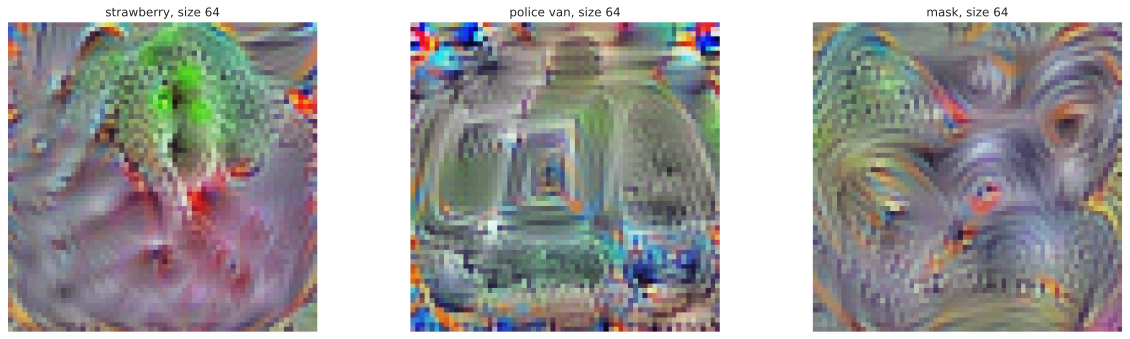

In [ ]:
import os

def save_patch_as_jpg(patch, save_path, cname, psize, dpi=300):
    # Convert the patch to a format that can be saved as an image
    patch = (torch.tanh(patch) + 1) / 2  # Convert parameter values to pixel values
    patch = patch.cpu().permute(1, 2, 0).numpy()  # Convert tensor to numpy
    patch = np.clip(patch, a_min=0.0, a_max=1.0)  # Ensure pixel values are in valid range

    # Save the patch as a .jpg file with the specified DPI (resolution)
    plt.imsave(f"{save_path}/{cname}_patch_size_{psize}.jpg", patch, dpi=dpi)

def show_and_save_patches(patch_dict, class_names, patch_sizes, save_path="patch_images", img_size=(6, 6), dpi=300):
    """
    Displays and saves patches with adjustable image size and DPI.
    :param patch_dict: Dictionary containing patches.
    :param class_names: List of class names.
    :param patch_sizes: List of patch sizes.
    :param save_path: Path to save the images.
    :param img_size: Tuple specifying (width, height) in inches for the overall figure.
    :param dpi: Dots per inch (resolution) for the saved images.
    """
    # Ensure the save path directory exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Adjust figure size based on img_size (width, height in inches)
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=img_size)

    # Handle cases where ax may not be a 2D array (i.e., if there's only one row/col)
    if len(patch_sizes) == 1:
        ax = [ax]  # Convert to a list for consistent indexing
    if len(class_names) == 1:
        ax = [[a] for a in ax]  # Ensure ax is a 2D array (list of lists)

    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]

            # Show the patch
            patch_img = (torch.tanh(patch) + 1) / 2  # Convert parameter values to pixel values
            patch_img = patch_img.cpu().permute(1, 2, 0).numpy()
            patch_img = np.clip(patch_img, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch_img)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')

            # Save each patch as a .jpg file with specified DPI (resolution)
            save_patch_as_jpg(patch, save_path, cname, psize, dpi=dpi)

    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()  # You can remove this if you only want to save and not display

# Example usage:
show_and_save_patches(patch_dict, class_names=['strawberry','police van','mask'], patch_sizes=[64], save_path="patch_images_1",img_size=(20, 20), dpi=800)


## References

[1] Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.

[2] Hendrik Metzen, Jan, et al. "Universal adversarial perturbations against semantic image segmentation." Proceedings of the IEEE International Conference on Computer Vision. 2017.

[3] Anant Jain. "Breaking neural networks with adversarial attacks." [Blog post](https://towardsdatascience.com/breaking-neural-networks-with-adversarial-attacks-f4290a9a45aa) 2019.

[4] Github Tutorial by Prof. Bent: [GitHub Link](https://github.com/AIPI-590-XAI/Duke-AI-XAI/tree/main)